In [27]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os

In [28]:
# Basic setting
name_data = "mnist"
model = "fcn"
objective = "fclassic"
T=6
recursive_step_1=False
split="geometric"
gamma_t_model = 0.5
gamma_ts = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [29]:
# load the base results using gamma=0.5
seed = 1
risk_laststep = False
exp_settings = f"{name_data}_{model}_{objective}_{split}_{T}_{recursive_step_1}_{risk_laststep}_{gamma_t_model}_{seed}.pt"

results_dir = f"./results/rpb/results_" + exp_settings
with open(results_dir, "rb") as handle:
    results = pickle.load(handle)

results

{'loss': [0.32095,
  array([0.78365594, 0.1452215 , 0.0408086 ], dtype=float32),
  array([0.93619555, 0.12423111, 0.04364444], dtype=float32),
  array([0.9511619 , 0.11352381, 0.03887619], dtype=float32),
  array([0.9566444 , 0.10682222, 0.03708889], dtype=float32),
  array([0.9612    , 0.10546666, 0.0375    ], dtype=float32)],
 'kl': [array(1204.8325, dtype=float32),
  array(1914.759, dtype=float32),
  array(213.77786, dtype=float32),
  array(78.52774, dtype=float32),
  array(44.032303, dtype=float32),
  array(22.95163, dtype=float32)],
 'excess_risk': [0.12800098261576423,
  0.0946932242643353,
  0.08000744959986618,
  0.07484186796354506,
  0.0771482604325109],
 'risk': [0.4260221793607181,
  0.3410120722961233,
  0.26519926041239694,
  0.21260707980606464,
  0.18114540786657737,
  0.16772096436579959],
 'train_loss': 0.1036,
 'test_loss': [0.3066, 0.1373, 0.1139, 0.1046, 0.103, 0.1019],
 'eval_time': 12242.415396928787}

In [53]:
# load analyze_gamma results from different t
exp_settings = f"{name_data}_{model}_{objective}_{split}_{T}_{recursive_step_1}_{gamma_t_model}_{seed}.pt"
exam_t = 6
results_dir = f"./results/rpb/results_gamma_{exam_t}_" + exp_settings
with open(results_dir, "rb") as handle:
    results_gamma = pickle.load(handle)

In [54]:
# check binarification of excess loss
print(f"t={exam_t}, T={T}")
for gamma in gamma_ts:
    print("gamma:", gamma, 
            " posterior:", results_gamma[exam_t][gamma]["loss_posterior"], "prior:", results_gamma[exam_t][gamma]["loss_prior"],
            "excess:", results_gamma[exam_t][gamma]["loss_excess_sum"], "E_t", results_gamma[exam_t][gamma]["E_t"]
            )

t=6, T=6
gamma: 0.0  posterior: [0.10486667] prior: [0.1056] excess: 0.10486666858196259 E_t 0.12759465006151652
gamma: 0.02  posterior: [0.104] prior: [0.10543333] excess: 0.10189133517444132 E_t 0.1254053964965713
gamma: 0.04  posterior: [0.10466667] prior: [0.10496667] excess: 0.10046799883246421 E_t 0.12302235465421367
gamma: 0.06  posterior: [0.10776667] prior: [0.10326667] excess: 0.10157066635787487 E_t 0.1255101039868335
gamma: 0.08  posterior: [0.10213333] prior: [0.108] excess: 0.0934933319687843 E_t 0.11626760434964871
gamma: 0.1  posterior: [0.10563333] prior: [0.1077] excess: 0.09486333318054674 E_t 0.11758462073431897
gamma: 0.2  posterior: [0.1017] prior: [0.1058] excess: 0.08053999915719029 E_t 0.10418708883936578
gamma: 0.3  posterior: [0.1033] prior: [0.1057] excess: 0.07158999964594837 E_t 0.09563898264091175
gamma: 0.4  posterior: [0.1032] prior: [0.1054] excess: 0.06104001253843311 E_t 0.08557372801437625
gamma: 0.5  posterior: [0.1032] prior: [0.10563333] excess: 

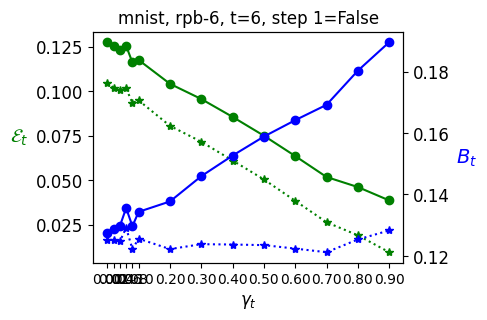

In [55]:
loss_excess_sum_gammas = {} # excess loss
E_t_gammas = {} # bound of excess loss
B_t_gammas = {} # risk
B_t_gammas_laststep = {} # risk without using recursion
B_t_minus_1 = results["risk"] # the base results, will use for recursion
if not recursive_step_1:
    ts = np.arange(1, T + 1)[1:]
else:
    ts = np.arange(1, T + 1)

for t in [exam_t]:#ts: # t from 2
    loss_excess_sum_gammas[t] = []
    E_t_gammas[t] = []
    B_t_gammas[t] = []
    B_t_gammas_laststep[t] = []
    B_t_gammas_laststep[t] = []
    
    for gamma_t in gamma_ts:
        loss_excess_sum_gamma_t = results_gamma[t][gamma_t]["loss_excess_sum"]
        E_t_gamma_t = results_gamma[t][gamma_t]["E_t"]
        B_t_gamma_t = E_t_gamma_t + gamma_t * B_t_minus_1[t-1]
        B_t_gamma_t_laststep = results_gamma[t][gamma_t]["laststep_B_t"]

        loss_excess_sum_gammas[t].append(loss_excess_sum_gamma_t)
        E_t_gammas[t].append(E_t_gamma_t)
        B_t_gammas[t].append(B_t_gamma_t)
        B_t_gammas_laststep[t].append(B_t_gamma_t_laststep)


    # Sample data
    x = gamma_ts
    y11 = E_t_gammas[t]
    y12 = loss_excess_sum_gammas[t]
    y21 = B_t_gammas[t]
    y22 = B_t_gammas_laststep[t]

    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots(figsize=(4, 3))

    # Plot the first set of data
    ax1.plot(x, y11, marker="o", color="g")  # 'g-' is a green solid line
    ax1.plot(x, y12, marker="*", color="g", linestyle="dotted") 

    ax1.set_xlabel(r"$\gamma_t$", fontsize=12)
    ax1.set_xticks(x)
    ax1.set_ylabel(r"$\mathcal{E}_t$", color="g", fontsize=14, rotation=0, labelpad=12)
    ax1.tick_params(axis="y", labelsize=12)
    #ax1.yaxis.set_label_coords(1, 0.5)

    # Create a twin Axes sharing the x-axis
    ax2 = ax1.twinx()

    # Plot the second set of data
    ax2.plot(x, y21, marker="o", color="b")  # 'b-' is a blue solid line
    ax2.plot(x, y22, marker="*", color="b", linestyle='dotted')  # 'b-' is a blue solid line
    ax2.set_ylabel(r"$B_t$", color="b", fontsize=14, rotation=0, labelpad=12)
    ax2.tick_params(axis="y", labelsize=12)

    # Show the plot
    plt.title(f"{name_data}, rpb-{T}, t={t}, step 1={recursive_step_1}")

    # Save the plot
    if not os.path.exists("./analyze_gamma"):
        os.makedirs("./analyze_gamma", exist_ok=True)
    plt.savefig(
        f"./analyze_gamma/gamma_{t}_{T}_{name_data}_{model}_{recursive_step_1}_{gamma_t_model}_{seed}.png", bbox_inches="tight"
    )
    plt.show()